In [1]:
# Import all the necessary libraries

import requests
from bs4 import BeautifulSoup
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt 
import seaborn as sns 
import os 

import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.sentiment import vader
from collections import Counter
from wordcloud import WordCloud
import datetime
from nltk import ngrams
from nltk.probability import FreqDist
import nltk.collocations as collocations
from nltk import FreqDist, bigrams
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF

In [2]:
base_url = "https://www.airlinequality.com/airline-reviews/kenya-airways/"
pages = 5
page_size = 100

reviews = []
date = []

for i in range(1, pages + 1):
    print(f"Scraping page {i}")
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"
    response = requests.get(url)
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')

    for review in parsed_content.find_all("article", {"itemprop": "review"}):
        # Extract review text
        review_text = review.find("div", {"class": "text_content"}).get_text()
        reviews.append(review_text)

        # Extract date
        try:
            review_date = review.find("div", {"class": "body"}).find("time").get_text()
        except AttributeError:
            review_date = "N/A"
        date.append(review_date)

    print(f"   ---> {len(reviews)} total reviews")


Scraping page 1
   ---> 100 total reviews
Scraping page 2
   ---> 200 total reviews
Scraping page 3
   ---> 300 total reviews
Scraping page 4
   ---> 400 total reviews
Scraping page 5
   ---> 419 total reviews


In [3]:
df = pd.DataFrame({"reviews":reviews, "date":date})
df.head()

,reviews,date
0,Not Verified | My family of 4 people had booke...,25th June 2023
1,Not Verified | I had booked a return flight f...,20th June 2023
2,✅ Trip Verified | I have been flying with Ken...,8th June 2023
3,✅ Trip Verified | At a time when many airline...,3rd June 2023
4,✅ Trip Verified | This is a bad airline. I tr...,26th May 2023


In [4]:
cwd = os.getcwd()
df.to_csv(cwd + "/data/KQ_reviews.csv") # Saves the dataframe as a csv file in the data folder.

In [5]:
# Inspect index 0

df['reviews'].get(0)

'Not Verified | My family of 4 people had booked to fly from Glasgow to Nairobi thru Amsterdam on 26 th June 2023. As they were preparing to fly, they received a message that the flight from Glasgow to Amsterdam is cancelled. Thus the re-booking is done for 2 people on 26 th and the other 2 on 27 th June. That would have messed all our onward plans. As today is a Sunday, we never got any response from the agent in Scotland who booked the tickets. As a last resort, with a prejudiced mind that I am just gambling, I called Kenya Airways number. The response I received was absolutely amazing. We got re-booking from Edinburgh to Amsterdam to reach Nairobi as planned earlier. I am really thankful.'

#### <b> Clean the dataset </b>

In [6]:
len(df['reviews']) # checks the length of the column "reviews"

419

In [7]:
# Creates a new column that extracts the information on whether the trip is verified or not

df['verified'] = df.reviews.str.contains("Trip Verified")
df['verified'].value_counts(normalize=True) # Checks the percentage value of the content in this new column.


False    0.637232
True     0.362768
Name: verified, dtype: float64

In [8]:
reviews_data = df.reviews.str.strip("✅ Trip Verified |")  
corpus =[]
# Instantiate the WordNetLemmatizer

lemma = WordNetLemmatizer()

#loop through each review, remove punctuations, small case it, join it and add it to corpus
for rev in reviews_data:
    rev = re.sub('[^a-zA-Z]',' ', rev)
    rev = rev.lower()
    rev = rev.split()
    rev = [lemma.lemmatize(word) for word in rev if word not in set(stopwords.words("english"))]
    rev = " ".join(rev)
    corpus.append(rev)

In [9]:
# add the corpus to the original dataframe

df['corpus'] = corpus
df

,reviews,date,verified,corpus
0,Not Verified | My family of 4 people had booke...,25th June 2023,False,verified family people booked fly glasgow nair...
1,Not Verified | I had booked a return flight f...,20th June 2023,False,verified booked return flight copenhagen momba...
2,✅ Trip Verified | I have been flying with Ken...,8th June 2023,True,flying kenya airway past year experienced dela...
3,✅ Trip Verified | At a time when many airline...,3rd June 2023,True,time many airline improving product kenya airw...
4,✅ Trip Verified | This is a bad airline. I tr...,26th May 2023,True,bad airline travelled kenya airway th may may ...
...,...,...,...,...
414,JNB-NBO-JNB. This trip showed both the good an...,18th July 2011,False,jnb nbo jnb trip showed good average side airl...
415,Nairobi-London. Lounge in Nairobi was small an...,17th July 2011,False,nairobi london lounge nairobi small food poor ...
416,Nairobi-London. As me and my wife are both whe...,11th July 2011,False,nairobi london wife wheelchair passenger charg...
417,LUN-LLW in Economy. Adequate for a 1 hr trip. ...,6th July 2011,False,lun llw economy adequate hr trip fa friendly q...


In [10]:
#Removing unwanted text(first text preprocessing)
df.replace(re.compile(r'\s*✅ Trip Verified \|\s*'), '', inplace=True)

df.head(8)

,reviews,date,verified,corpus
0,Not Verified | My family of 4 people had booke...,25th June 2023,False,verified family people booked fly glasgow nair...
1,Not Verified | I had booked a return flight f...,20th June 2023,False,verified booked return flight copenhagen momba...
2,I have been flying with Kenya Airways for the ...,8th June 2023,True,flying kenya airway past year experienced dela...
3,At a time when many airlines are improving the...,3rd June 2023,True,time many airline improving product kenya airw...
4,This is a bad airline. I travelled with Kenya ...,26th May 2023,True,bad airline travelled kenya airway th may may ...
5,"Missed outward leg of a return flight, due to ...",30th April 2023,True,missed outward leg return flight due issue ka ...
6,"Very good flight, excellent crew on board, as ...",1st April 2023,True,good flight excellent crew board food drink gr...
7,Kigali - Nairobi - Entebbe return 26-27 March ...,29th March 2023,True,kigali nairobi entebbe return march aircraft n...


In [11]:
# convert the date to datetime format

df.date = pd.to_datetime(df.date)

df.head()

,reviews,date,verified,corpus
0,Not Verified | My family of 4 people had booke...,2023-06-25,False,verified family people booked fly glasgow nair...
1,Not Verified | I had booked a return flight f...,2023-06-20,False,verified booked return flight copenhagen momba...
2,I have been flying with Kenya Airways for the ...,2023-06-08,True,flying kenya airway past year experienced dela...
3,At a time when many airlines are improving the...,2023-06-03,True,time many airline improving product kenya airw...
4,This is a bad airline. I travelled with Kenya ...,2023-05-26,True,bad airline travelled kenya airway th may may ...


In [12]:
df.isna().sum()

reviews     0
date        0
verified    0
corpus      0
dtype: int64

In [13]:
# Cleaned data 
df.to_csv( cwd + "/data/KQ_reviews_cleaned.csv")

## <b> EDA </b>

In [14]:
# an instance of SentimentIntensityAnalyzer
sentiment_analyzer = vader.SentimentIntensityAnalyzer()

# a new column named 'sentiment'
df['sentiment'] = df['reviews'].apply(
    lambda review: sentiment_analyzer.polarity_scores(review)['compound']
    )
df

,reviews,date,verified,corpus,sentiment
0,Not Verified | My family of 4 people had booke...,2023-06-25,False,verified family people booked fly glasgow nair...,0.4915
1,Not Verified | I had booked a return flight f...,2023-06-20,False,verified booked return flight copenhagen momba...,-0.9519
2,I have been flying with Kenya Airways for the ...,2023-06-08,True,flying kenya airway past year experienced dela...,-0.9888
3,At a time when many airlines are improving the...,2023-06-03,True,time many airline improving product kenya airw...,0.4284
4,This is a bad airline. I travelled with Kenya ...,2023-05-26,True,bad airline travelled kenya airway th may may ...,-0.6742
...,...,...,...,...,...
414,JNB-NBO-JNB. This trip showed both the good an...,2011-07-18,False,jnb nbo jnb trip showed good average side airl...,0.8201
415,Nairobi-London. Lounge in Nairobi was small an...,2011-07-17,False,nairobi london lounge nairobi small food poor ...,0.9826
416,Nairobi-London. As me and my wife are both whe...,2011-07-11,False,nairobi london wife wheelchair passenger charg...,0.9485
417,LUN-LLW in Economy. Adequate for a 1 hr trip. ...,2011-07-06,False,lun llw economy adequate hr trip fa friendly q...,0.6808


In [15]:
# Creating another new column called 'sentiment_type' that contains the type of sentiment of each review using nltk
# for each sentiment score in the 'SENTIMENT' column
df['sentiment_type'] = df['sentiment'].apply(
    lambda score: 'positive' if score > 0 else ('negative' if score < 0 else 'neutral')
    )
df #inspect the dataframe

,reviews,date,verified,corpus,sentiment,sentiment_type
0,Not Verified | My family of 4 people had booke...,2023-06-25,False,verified family people booked fly glasgow nair...,0.4915,positive
1,Not Verified | I had booked a return flight f...,2023-06-20,False,verified booked return flight copenhagen momba...,-0.9519,negative
2,I have been flying with Kenya Airways for the ...,2023-06-08,True,flying kenya airway past year experienced dela...,-0.9888,negative
3,At a time when many airlines are improving the...,2023-06-03,True,time many airline improving product kenya airw...,0.4284,positive
4,This is a bad airline. I travelled with Kenya ...,2023-05-26,True,bad airline travelled kenya airway th may may ...,-0.6742,negative
...,...,...,...,...,...,...
414,JNB-NBO-JNB. This trip showed both the good an...,2011-07-18,False,jnb nbo jnb trip showed good average side airl...,0.8201,positive
415,Nairobi-London. Lounge in Nairobi was small an...,2011-07-17,False,nairobi london lounge nairobi small food poor ...,0.9826,positive
416,Nairobi-London. As me and my wife are both whe...,2011-07-11,False,nairobi london wife wheelchair passenger charg...,0.9485,positive
417,LUN-LLW in Economy. Adequate for a 1 hr trip. ...,2011-07-06,False,lun llw economy adequate hr trip fa friendly q...,0.6808,positive


In [16]:
# calculate the percentage of each type of sentiment score
sent_type_percentages = df['sentiment_type'].value_counts(normalize=True)
sent_type_percentages

negative    0.508353
positive    0.491647
Name: sentiment_type, dtype: float64

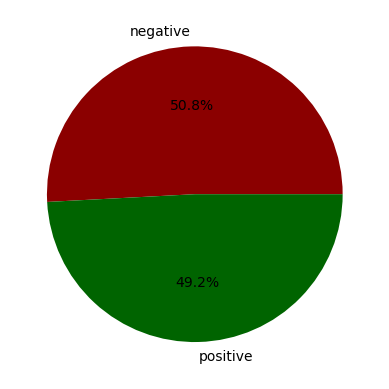

In [17]:
# Plot the sentiment percentages 

# create the pie chart
fig, ax = plt.subplots()
ax.pie(
    sent_type_percentages,
    labels=sent_type_percentages.index, 
    colors=['darkred', 'darkgreen'], 
    autopct='%1.1f%%'
    )

plt.show()

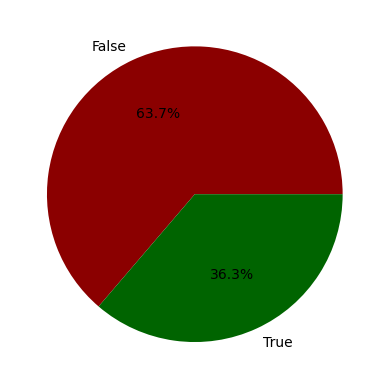

In [18]:
# Plot the verified reviews 
verified_pctg = df['verified'].value_counts(normalize=True)

# create the pie chart
fig, ax = plt.subplots()
ax.pie(
    verified_pctg,
    labels=verified_pctg.index, 
    colors=['darkred', 'darkgreen'], 
    autopct='%1.1f%%'
    )

plt.show()

In [19]:
df.to_csv( cwd + "/data/KQ_sentiment_analysis_data.csv")

In [20]:
# make a frequency chart that will tell us the key topics that are mentioned in the reviews

reviews = df['corpus']

# Convert the reviews into a list of words 

words = []
for review in reviews:
    words.extend(review.split())
    

# Filter out the remaining stopwords

stopwords = nltk.corpus.stopwords.words('english')
key_words = [word for word in words if word not in stopwords and word not in ['I', 'The','would','one','get','-']]


In [21]:
# Get the top 20 most used words 
word_counts = Counter(key_words)
top_20_words = word_counts.most_common(20)

# Filter out any of the remaining stop words 
filtered_words = [
    (word, count) for word, count in top_20_words if word not in stopwords and word not in ['I', 'The','would','one','get','-']
    ]


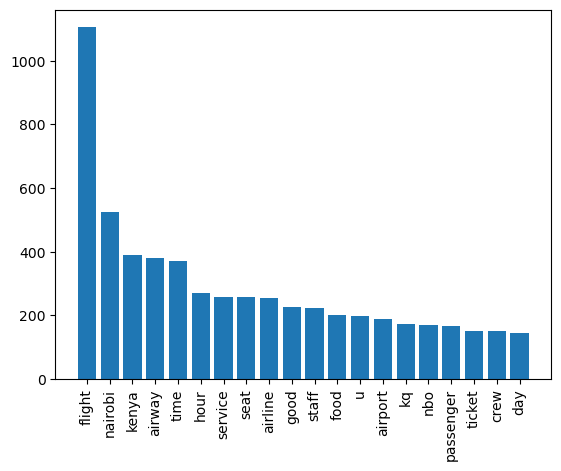

In [22]:
# Get the labels and values for the histogram
labels, values = zip(*top_20_words)

# Create the histogram
plt.bar(labels, values)

# Set the x-axis labels to be vertical
plt.xticks(rotation=90)

#Display the plot
plt.show()


## Time series analysis

In [23]:
#convert the date datatype to datetime

df.date = pd.to_datetime(df.date)
fig = px.line(df, x='date')
fig.show()

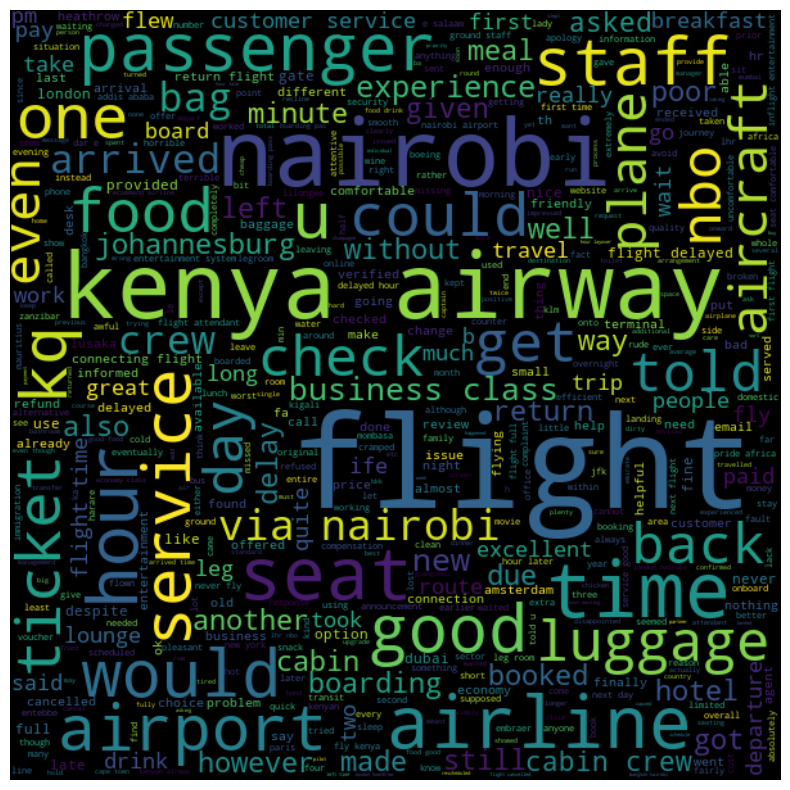

In [24]:
# Start with one review:
reviews = " ".join(df.corpus)
plt.figure(figsize=(20,10))

# Create and generate a word cloud image:
wordcloud = WordCloud(height=600,width=600,max_font_size=100, max_words=500, stopwords=stopwords).generate(reviews)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [25]:
#split the text of all reviews into a list of words
words = reviews.split(" ")

#remove certain words that will not be used to determine the positive or negative sentiment
stopwords = text.ENGLISH_STOP_WORDS.union(['flight', 'kq', "passenger","u","airway","airline",
                                           "nairobi","plane","via","nbo"])


new_words = [word for word in words if word not in stopwords]

nlp_words=FreqDist(new_words).most_common(20)

#create a dataframe of these word and its frequencies
all_fdist = pd.Series(dict(nlp_words))

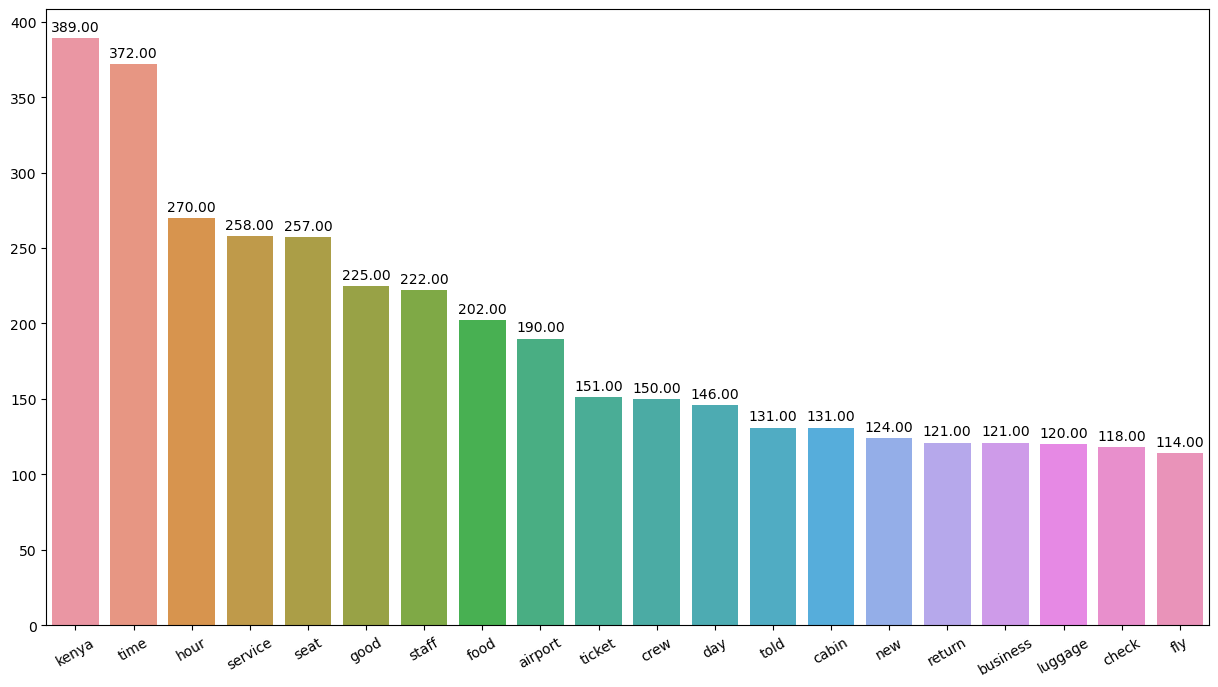

In [26]:
# Setting figure, ax into variables
fig, ax = plt.subplots(figsize=(15, 8))

# Seaborn plotting using Pandas attributes + xtick rotation for ease of viewing
all_plot = sns.barplot(x=all_fdist.index, y=all_fdist.values, ax=ax)

# Add labels to the bars
for container in all_plot.containers:
    for rect in container:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), textcoords='offset points',
                    ha='center', va='bottom')

# Rotate x-axis tick labels for better visibility
plt.xticks(rotation=30)

# Display the plot
plt.show()

### <b> Word Frequency using N-gram </b>

<AxesSubplot:>

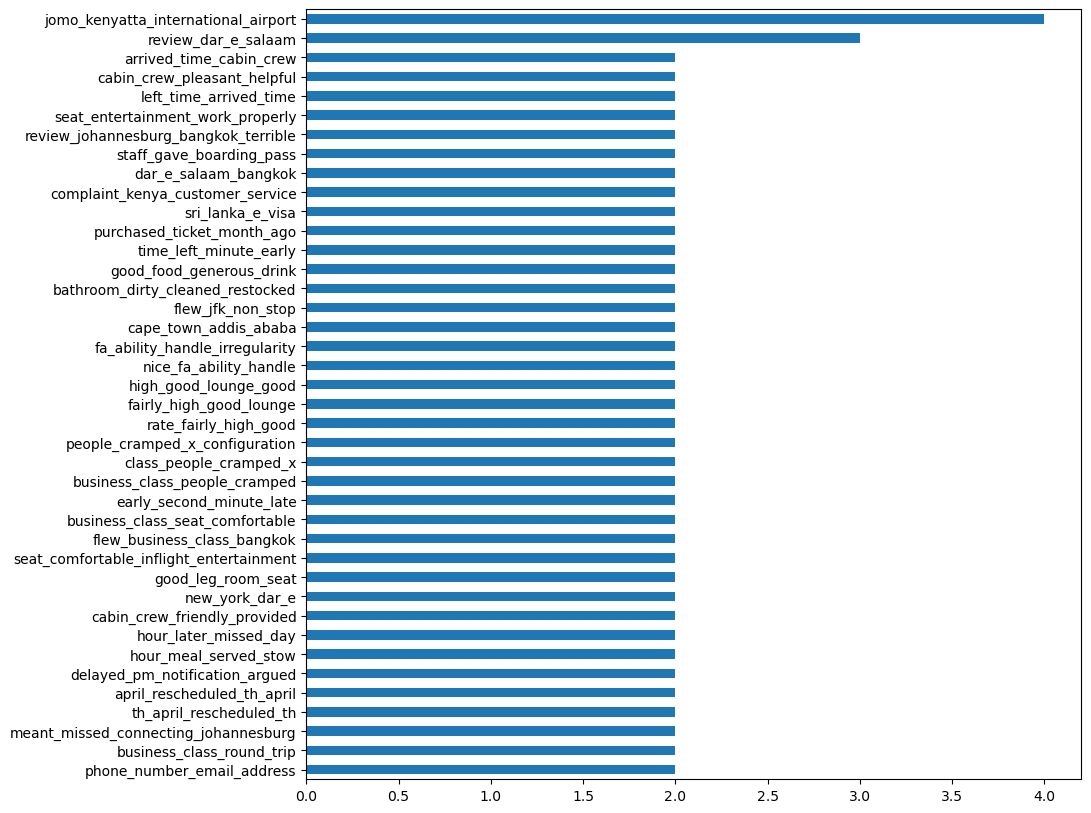

In [27]:
reviews = " ".join(df.corpus)

# Split the text of all reviews into a list of words
words = reviews.split(" ")

new_words = [word for word in words if word not in stopwords]

def get_freq_dist(new_words, number_of_ngrams):
    # Generate n-grams
    ngrams_list = list(ngrams(new_words, number_of_ngrams))

    # Creating FreqDist
    ngram_fd = FreqDist(ngrams_list).most_common(40)

    # Sort values by highest frequency
    ngram_sorted = {k: v for k, v in sorted(ngram_fd, key=lambda item: item[1])}

    # Join n-gram tokens with '_' and maintain sorting
    ngram_joined = {'_'.join(k): v for k, v in sorted(ngram_fd, key=lambda item: item[1])}

    # Convert to Pandas Series for easy plotting
    ngram_freqdist = pd.Series(ngram_joined)
    plt.figure(figsize=(10, 10))
    ax = ngram_freqdist.plot(kind="barh")

    return ax

get_freq_dist(new_words, 4)


In [28]:
%%capture
vds = SentimentIntensityAnalyzer()
# text = 'This is an extremely entertaining movie'

#set a column Polarity with all 0 values initially
df['label'] = 0
    
for i in range(len(df.corpus)):
    
    score = vds.polarity_scores(df.corpus[i])['compound']
    #print(score)
    if score > 0.2:
        df['label'][i] = 1
        #print("1st")
    elif score < 0:
        df['label'][i] = -1
        #print("2nd")
    else:
        df['label'][i] = 0


In [29]:
df.label.value_counts()


 1    230
-1    174
 0     15
Name: label, dtype: int64

In [30]:
from sklearn.feature_extraction.text import CountVectorizer

# Create an object of CountVectorizer
vect = CountVectorizer()

# Convert the corpus to a list of strings (if not already)
corpus = df.corpus.tolist()

# Apply transformation
tf = vect.fit_transform(corpus)
tf_array = tf.toarray()

# Get the feature names
tf_feature_names = vect.get_feature_names_out()

In [31]:
#declare the number of topics
number_of_topics = 8

model = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)

#fit the term frequency data to the model
model.fit(tf)

#create empty dictionary to store key value pair of topic number and its weights
topic_dict = {}

#loop through model components 
for topic_idx, topic in enumerate(model.components_):
    topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(tf_feature_names[i])
            for i in topic.argsort()[:-10 - 1:-1]]
    topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
            for i in topic.argsort()[:-10 - 1:-1]]
    
df_topic = pd.DataFrame(topic_dict)

df_topic

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,Topic 5 words,Topic 5 weights,Topic 6 words,Topic 6 weights,Topic 7 words,Topic 7 weights
0,good,15.4,flight,72.0,flight,39.5,flight,377.9,flight,22.2,flight,571.2,back,10.9,crew,19.2
1,food,10.6,kq,42.2,nairobi,25.7,seat,192.2,service,20.3,nairobi,257.5,service,10.3,kq,16.8
2,airline,7.9,nairobi,40.8,seat,24.8,time,188.2,staff,18.7,kenya,242.8,airway,9.6,time,14.9
3,time,7.3,passenger,38.4,time,18.6,good,188.1,bag,13.8,airway,228.5,nairobi,9.5,hour,14.8
4,bad,7.1,check,31.5,food,17.9,nairobi,161.7,nairobi,12.3,hour,189.1,refund,8.6,nairobi,13.2
5,given,6.9,johannesburg,30.3,return,15.6,nbo,152.5,airline,11.0,airline,134.4,would,8.4,flight,12.7
6,bus,6.6,time,29.7,leg,14.8,service,138.5,go,9.9,ticket,125.2,staff,8.1,staff,12.6
7,line,6.5,airway,29.4,poor,14.4,food,134.5,rude,9.4,day,117.2,ka,7.9,cabin,12.5
8,one,6.5,bag,28.7,passenger,12.1,crew,114.5,food,9.1,told,112.0,asked,7.7,good,11.8
9,seat,6.4,luggage,27.6,ife,11.5,cabin,100.9,ground,9.0,airport,107.5,need,7.6,food,11.3


### <b> Topic modeling with NMF

In [32]:
nmf = NMF(n_components=2, init='random', random_state=0)
nmf.fit_transform(tf)

array([[9.61168797e-02, 0.00000000e+00],
       [4.39957580e-01, 0.00000000e+00],
       [3.42775091e-01, 9.08913567e-02],
       [1.41280745e-01, 3.08981382e-01],
       [8.22935670e-02, 0.00000000e+00],
       [1.26722407e-01, 1.26331002e-01],
       [0.00000000e+00, 1.12335851e-01],
       [1.84818039e-01, 7.08963832e-01],
       [3.68344691e-01, 1.40427928e-02],
       [1.15583696e-01, 1.80564253e-01],
       [2.00919384e-02, 1.13497519e-01],
       [1.73137549e-01, 0.00000000e+00],
       [1.08570957e-01, 2.01389633e-02],
       [1.35377305e-01, 8.81005904e-02],
       [1.12817130e-01, 0.00000000e+00],
       [1.51528548e-01, 7.54389182e-02],
       [6.22111522e-02, 3.08244459e-02],
       [2.49671843e-02, 2.97605264e-01],
       [3.22337646e-03, 9.16348265e-02],
       [1.23153907e-01, 1.69082282e-02],
       [2.62237602e-02, 9.30785034e-02],
       [5.54389160e-02, 2.02672294e-02],
       [9.95147553e-02, 1.92123929e-01],
       [8.46480717e-02, 7.76377790e-02],
       [5.539372

In [33]:
topic_dict = {}

#loop through model components 
for topic_idx, topic in enumerate(nmf.components_):
    topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(tf_feature_names[i])
            for i in topic.argsort()[:-10 - 1:-1]]
    topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
            for i in topic.argsort()[:-10 - 1:-1]]
    
df_topic =pd.DataFrame(topic_dict)

df_topic

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights
0,flight,17.7,flight,8.1
1,kenya,10.5,time,4.2
2,airway,10.4,seat,4.1
3,nairobi,6.8,nairobi,3.6
4,hour,5.2,good,3.5
5,ticket,4.9,food,2.8
6,would,3.9,nbo,2.7
7,airport,3.9,kq,2.5
8,told,3.8,service,2.2
9,day,3.5,cabin,2.0
